<img align="right" style="max-width: 200px; height: auto" src="cfds_logo.png">

###  Lab 03 - "Moving Average Trading Strategies"

Chartered Financial Data Scientist (CFDS), Spring Term 2020

In this introductory lab, we create our first **financial data science process**. The main objective of this lab is to walk you through the general process of implementing and evaluating a simple **trend-following** trading strategy. To achieve this, we will follow the distinct process steps as outlined below:

<img align="middle" style="max-width: 600px; height: auto" src="fds_process.png">

As always, pls. don't hesitate to ask all your questions either during the lab or send us an email (using our
fds.ai email addresses).

### Lab Objectives:

After today's lab you should be able to:
    
> 1. Implement a **trend-following trading strategy** and apply it to distinct financial instruments.
> 2. Convert the trading strategy results into **trade signals** to be used in backtest.
> 3. Understand how to use the **python backtesting bt** library to backtest the implemented strategy.
> 4. Interpret the backtests results using the distinct **backtest performance** measures.

Before we start let's watch a motivational video:

In [1]:
from IPython.display import YouTubeVideo
# Nvidia GTC 2017: "I Am AI" Opening in Keynote"
# YouTubeVideo('SUNPrR4o5ZA', width=800, height=600)

### Setup of the Analysis Environment

We need to import a couple of Python libraries that allow for data analysis and data visualization. In this lab will use the `Pandas`, `NumPy`, `BT` and the `Matplotlib` library. Let's import the libraries by the execution of the statements below:

In [ ]:
# import python utility libraries
import os as os
import datetime as dt
import itertools as it

# import python data science libraries
import pandas as pd
import numpy as np

# import the pandas financial data reader library
import yfinance as yf

# import the Python bt backtest library
import bt as bt

# import the matplotlib and seaborn visualization library
import matplotlib.pyplot as plt
import seaborn as sns

Let's also set a couple of general plot parameters:

In [9]:
# set general plot parameters
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

Enable inline Jupyter notebook plotting:

In [10]:
%matplotlib inline

Suppress potential warnings due to recent library enhancements:

In [11]:
import warnings
warnings.filterwarnings('ignore')

Create a **dataset** sub-folder that we will use to store the financial data downloaded:

In [12]:
if not os.path.exists('./datasets'): os.makedirs('./datasets')

### 1. Acquire the Financial Data

In this section of the lab notebook, we will aquire historic daily stock market data of the **"International Business Machines" (IBM)** corporation (ticker symbol: "IBM"). Thereby, we will utilize the `yfinance` library that provides the ability to interface the `Yahoo` finance API. Let's first specify the start date and end date of the data download. We aim to download market price data starting from the **31.12.1990** until the **31.12.2017** to develop and evaluate a simple momentum trading strategy:

In [13]:
# set to start and end date of the data download
start_date = dt.datetime(1990, 12, 31)
end_date = dt.datetime(2017, 12, 31)

Download the **daily** "International Business Machines" (IBM) market data of the defined timeframe using the `datareader`'s `Yahoo` finance API:

In [14]:
# download ibm market data
ibm_data = yf.Ticker("IBM").history(start=start_date, end=end_date)

### 2. Pre-Process the Financial Data

Inspect the top 10 records of the `IBM` data downloaded:

In [15]:
ibm_data.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1990-12-31 00:00:00-05:00,11.848719,11.861783,11.796464,11.809528,1930079,0.0,0.0
1991-01-02 00:00:00-05:00,11.796461,11.887907,11.718080,11.718080,4341737,0.0,0.0
1991-01-03 00:00:00-05:00,11.744212,11.900975,11.731148,11.757276,5470162,0.0,0.0
1991-01-04 00:00:00-05:00,11.783398,11.809526,11.691953,11.718080,4540058,0.0,0.0
1991-01-07 00:00:00-05:00,11.639700,11.691955,11.496000,11.522127,4976450,0.0,0.0
1991-01-08 00:00:00-05:00,11.535192,11.535192,11.365364,11.391491,7177652,0.0,0.0
1991-01-09 00:00:00-05:00,11.469873,11.574382,11.156346,11.169409,8694352,0.0,0.0
1991-01-10 00:00:00-05:00,11.247793,11.326175,11.208602,11.326175,4025008,0.0,0.0
1991-01-11 00:00:00-05:00,11.273914,11.313105,11.260851,11.300041,2546801,0.0,0.0


Visually inspect the **adjusted closing price** of the downloaded `IBM` data:

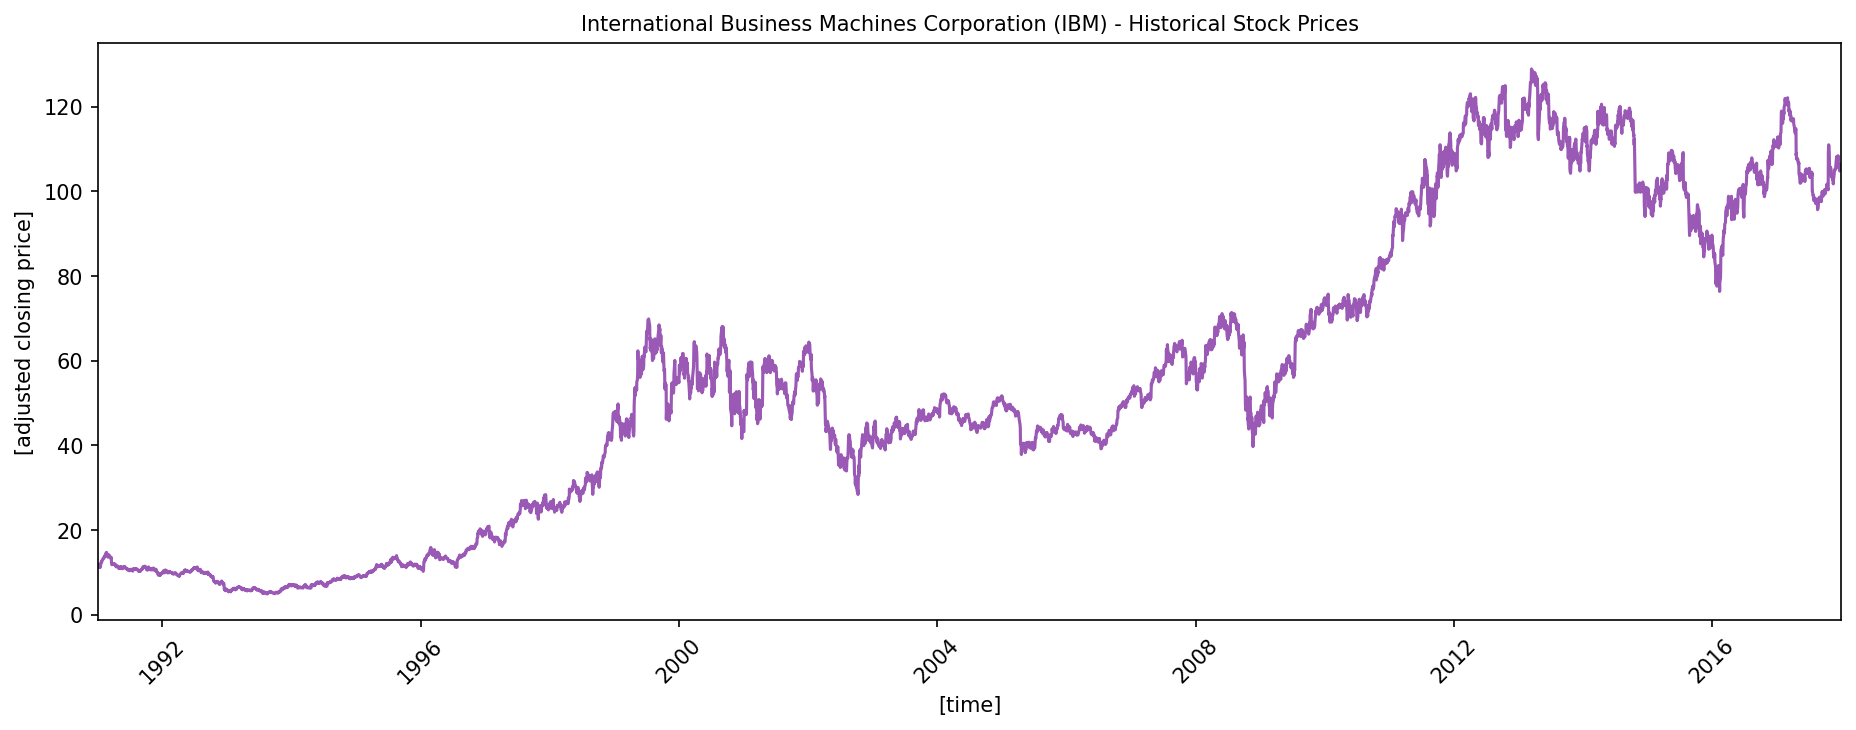

In [17]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot ibm stock daily adjusted closing prices
ax.plot(ibm_data.index, ibm_data['Close'], color='#9b59b6')

# rotate x-ticks
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[adjusted closing price]', fontsize=10)

# set plot title
plt.title('International Business Machines Corporation (IBM) - Historical Stock Prices', fontsize=10);

Save the downloaded `IBM` data to the local directory:

In [ ]:
ibm_data.to_csv('./datasets/ibm_data_1990_2017_daily.csv', sep=';', encoding='utf-8')

### 3. Data Analysis - Moving Average Crossover Strategy Implementation

Let's implement a simple **Moving Average Crossover** trading strategy. In general, **crossover trading** refers to the idea that changes of market situations can be determined based on price “breakouts”. A crossover can be interpreted as another measure of a financial instruments momentum. In the past crossover signals have been extensively used to determine that it’s time to either buy or sell the underlying asset.

The price crossover signals of a simple **Moving Average Crossover** trading strategy are triggered by the following events:

>- Generate a **short** trading signal once the price of a financial instrument drops below the general price trend, e.g., 100-days moving average band ("Sell Sign Crossover", left image below). 
>- Generate a **long** trading signal once the price of a financial instrument exceeds the general price trend, e.g., 100-days moving average band ("Buy Sign Crossover", right image below).

<img align="middle" style="max-width: 800px; height: auto" src="crossovertrading.png">

An enhancement of the **Moving Average Crossover** is to apply two moving averages to a chart: one long running moving average (e.g., a 200-days SMAV) and one short running moving average (e.g., 20-days SMAV). Once the short running moving average crosses above the long running moving average a **Buy** or **Long** signal is triggered, as it indicates that the trend is shifting up (this is known as a "golden cross"). On the other hand, when the short running moving average crosses below the long running moving average, a **Sell** or **Short** signal is triggered, as it indicates that the trend is shifting down (his is known as a "dead/death cross")

Let's start implementing this enhanced trading strategy by setting the distinct moving average window sizes that specify the number of historical daily adjusted closing prices of the IBM stock to be considered in the calculation of the rolling moving average:

In [18]:
cross_mav_days_15 = 15  # set "fast" short-running moving average indicator lookback, days = 15
cross_mav_days_60 = 60  # set "slow" short-running moving average indicator lookback, days = 60
cross_mav_days_200 = 200  # set "trend" long-running moving average indicator lookback, days = 200

Calculate the rolling moving averages of window sizes: 15 days, 50 days and 200 days. In general the **"Simple Moving Average (SMAV)"** of a financial instrument $i$ (e.g., a stock, commodity, fx-rate) is defined as the mean of the previous $n$ prices, formally denoted by: 


$$SMA_{i}(t)=\frac{1}{n} \sum_{k=0}^{n-1} p_{i}(t-k)$$

were $t$ denotes the current point in time and $n$ the lookback.

We can calculate the SMAV by just using the Pandas `rolling()` and `mean()`function:

In [60]:
cross_mav_15 = pd.Series(ibm_data['Close'].rolling(window = cross_mav_days_15).mean(), name = 'SMAV_15')
cross_mav_60 = pd.Series(ibm_data['Close'].rolling(window = cross_mav_days_60).mean(), name = 'SMAV_60')
cross_mav_200 = pd.Series(ibm_data['Close'].rolling(window = cross_mav_days_200).mean(), name = 'SMAV_200')

Bear in mind that the rolling average leaves NaN values at the begining of the computed window.

In [73]:
#cross_mav_15.iloc[5:25]
#cross_mav_60.iloc[45:80]
cross_mav_200.iloc[185:210]

Date
1991-09-24 00:00:00-04:00          NaN
1991-09-25 00:00:00-04:00          NaN
1991-09-26 00:00:00-04:00          NaN
1991-09-27 00:00:00-04:00          NaN
1991-09-30 00:00:00-04:00          NaN
1991-10-01 00:00:00-04:00          NaN
1991-10-02 00:00:00-04:00          NaN
1991-10-03 00:00:00-04:00          NaN
1991-10-04 00:00:00-04:00          NaN
1991-10-07 00:00:00-04:00          NaN
1991-10-08 00:00:00-04:00          NaN
1991-10-09 00:00:00-04:00          NaN
1991-10-10 00:00:00-04:00          NaN
1991-10-11 00:00:00-04:00          NaN
1991-10-14 00:00:00-04:00    11.556538
1991-10-15 00:00:00-04:00    11.553815
1991-10-16 00:00:00-04:00    11.550130
1991-10-17 00:00:00-04:00    11.545305
1991-10-18 00:00:00-04:00    11.540945
1991-10-21 00:00:00-04:00    11.537498
1991-10-22 00:00:00-04:00    11.533758
1991-10-23 00:00:00-04:00    11.531129
1991-10-24 00:00:00-04:00    11.527581
1991-10-25 00:00:00-04:00    11.524029
1991-10-28 00:00:00-05:00    11.521330
Name: SMAV_200, dtyp

Merge the rolling moving average values with the original market data (adjusted closing prices):

In [98]:
cross_mav_ibm_data = ibm_data.join(cross_mav_15)
cross_mav_ibm_data = cross_mav_ibm_data.join(cross_mav_60)
cross_mav_ibm_data = cross_mav_ibm_data.join(cross_mav_200)

Inspect and validate the daily adjusted closing prices of the IBM stock as well as the derived moving average values starting from the first obtained 200-day moving average market price:
We will truncate the set to remove all the NaN values.

In [99]:
cross_mav_ibm_data = cross_mav_ibm_data[['Close', 'SMAV_15', 'SMAV_60', 'SMAV_200']].iloc[200:]
cross_mav_ibm_data.head(10)

,Close,SMAV_15,SMAV_60,SMAV_200
Date,,,,
1991-10-15 00:00:00-04:00,11.264893,10.920914,10.789731,11.553815
1991-10-16 00:00:00-04:00,10.981244,10.896601,10.793703,11.550130
1991-10-17 00:00:00-04:00,10.792146,10.860582,10.794301,11.545305
1991-10-18 00:00:00-04:00,10.846176,10.847075,10.796244,11.540945
1991-10-21 00:00:00-04:00,10.832662,10.822762,10.797962,11.537498
1991-10-22 00:00:00-04:00,10.643572,10.793047,10.794972,11.533758
1991-10-23 00:00:00-04:00,10.643572,10.774137,10.791537,11.531129
1991-10-24 00:00:00-04:00,10.616555,10.768734,10.788319,11.527581
1991-10-25 00:00:00-04:00,10.589543,10.766933,10.784650,11.524029


Plot the historical daily adjusted closing prices of the IBM stock as well as its 15 days, 60 days as well as 200 days rolling moving averages:

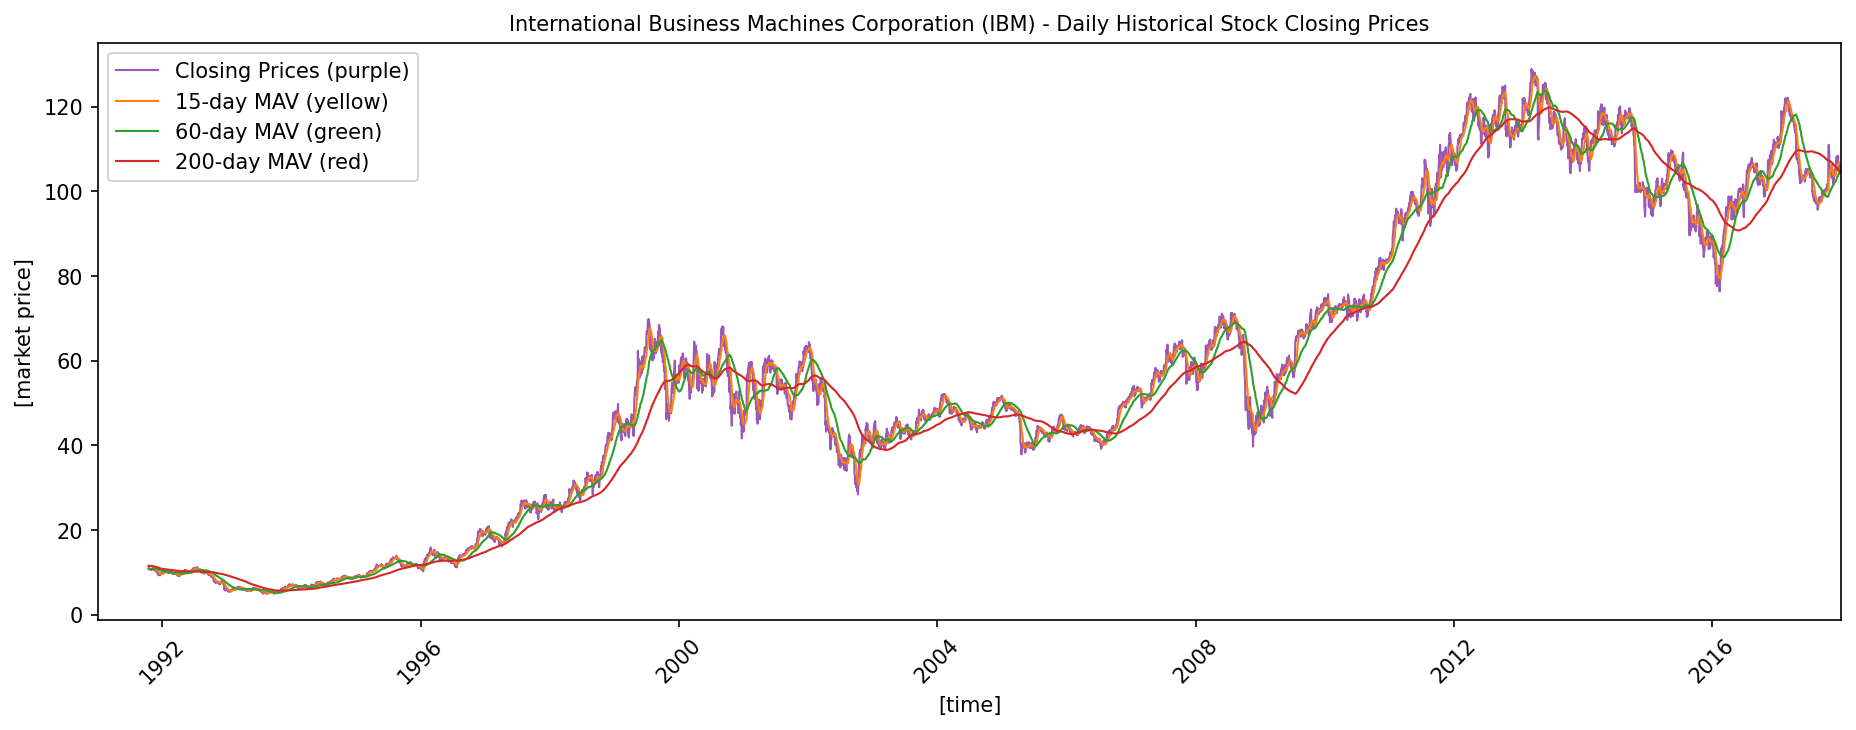

In [100]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot adjusted closing prices and moving averages
ax.plot(cross_mav_ibm_data['Close'], lw=1.0, color='#9b59b6', label='Closing Prices (purple)')
ax.plot(cross_mav_ibm_data['SMAV_15'], color='C1',lw=1.0, label='15-day MAV (yellow)')
ax.plot(cross_mav_ibm_data['SMAV_60'], color='C2',lw=1.0, label='60-day MAV (green)')
ax.plot(cross_mav_ibm_data['SMAV_200'], color='C3', lw=1.0, label='200-day MAV (red)')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[market price]', fontsize=10)

# set plot legend
plt.legend(loc="upper left", numpoints=1, fancybox=True)

# set plot title
plt.title('International Business Machines Corporation (IBM) - Daily Historical Stock Closing Prices', fontsize=10);

### 4. Moving Average Crossover Signal Generation

Derive trading signals from of two distinct moving average crossover trading strategy configurations. We will generate a **long-signal** (+1.0) for the time intervals where the fast moving averages are above the 200-day moving average. In addition we generate a **short-signal** (-1.0) for the time intervals where the fast moving averages are below the 200-day moving average:

In [101]:
# create 'fast' trend-following signals
cross_mav_ibm_data['SIGNAL_15'] = 0.0
cross_mav_ibm_data.loc[cross_mav_ibm_data['SMAV_15'] > cross_mav_ibm_data['SMAV_200'], 'SIGNAL_15'] = 1.0
cross_mav_ibm_data.loc[cross_mav_ibm_data['SMAV_15'] < cross_mav_ibm_data['SMAV_200'], 'SIGNAL_15'] = -1.0

# create 'slow' trend-following signals
cross_mav_ibm_data['SIGNAL_60'] = 0.0
cross_mav_ibm_data.loc[cross_mav_ibm_data['SMAV_60'] > cross_mav_ibm_data['SMAV_200'], 'SIGNAL_60'] = 1.0
cross_mav_ibm_data.loc[cross_mav_ibm_data['SMAV_60'] < cross_mav_ibm_data['SMAV_200'], 'SIGNAL_60'] = -1.0

In addition, let's also prepare a backtest of a **"baseline"** in terms of a simple **buy-and-hold** trading strategy for comparison purposes. Our buy-and-hold strategy sends a "long" (+1.0) signal for each time step: 

In [102]:
cross_mav_ibm_data['SIGNAL_BASE'] = 1.0

Lets inspect again the head of our set to see the new columns and its values.
Inspecting the object we work with is a good way of ensuring everything is going alright.
Lets see if in some places we find different signals.

In [103]:
cross_mav_ibm_data.head(10)

,Close,SMAV_15,SMAV_60,SMAV_200,SIGNAL_15,SIGNAL_60,SIGNAL_BASE
Date,,,,,,,
1991-10-15 00:00:00-04:00,11.264893,10.920914,10.789731,11.553815,-1.0,-1.0,1.0
1991-10-16 00:00:00-04:00,10.981244,10.896601,10.793703,11.550130,-1.0,-1.0,1.0
1991-10-17 00:00:00-04:00,10.792146,10.860582,10.794301,11.545305,-1.0,-1.0,1.0
1991-10-18 00:00:00-04:00,10.846176,10.847075,10.796244,11.540945,-1.0,-1.0,1.0
1991-10-21 00:00:00-04:00,10.832662,10.822762,10.797962,11.537498,-1.0,-1.0,1.0
1991-10-22 00:00:00-04:00,10.643572,10.793047,10.794972,11.533758,-1.0,-1.0,1.0
1991-10-23 00:00:00-04:00,10.643572,10.774137,10.791537,11.531129,-1.0,-1.0,1.0
1991-10-24 00:00:00-04:00,10.616555,10.768734,10.788319,11.527581,-1.0,-1.0,1.0
1991-10-25 00:00:00-04:00,10.589543,10.766933,10.784650,11.524029,-1.0,-1.0,1.0


Prepare the trading signal data to be utilized in backtesting the long-/short-term moving-average trading strategy:

In [106]:
# convert signals to Pandas DataFrame
cross_mav_ibm_signal_data = pd.DataFrame(cross_mav_ibm_data[['SIGNAL_15', 'SIGNAL_60', 'SIGNAL_BASE']], columns=['SIGNAL_15', 'SIGNAL_60', 'SIGNAL_BASE'])

# convert pandas DataFrame index to datatype: datetime
#cross_mav_ibm_signal_data = cross_mav_ibm_signal_data.set_index(pd.to_datetime(ibm_data.index))

Inspect top 10 rows of the prepared trading signals:

In [107]:
cross_mav_ibm_signal_data.head(10)

,SIGNAL_15,SIGNAL_60,SIGNAL_BASE
Date,,,
1991-10-15 00:00:00-04:00,-1.0,-1.0,1.0
1991-10-16 00:00:00-04:00,-1.0,-1.0,1.0
1991-10-17 00:00:00-04:00,-1.0,-1.0,1.0
1991-10-18 00:00:00-04:00,-1.0,-1.0,1.0
1991-10-21 00:00:00-04:00,-1.0,-1.0,1.0
1991-10-22 00:00:00-04:00,-1.0,-1.0,1.0
1991-10-23 00:00:00-04:00,-1.0,-1.0,1.0
1991-10-24 00:00:00-04:00,-1.0,-1.0,1.0
1991-10-25 00:00:00-04:00,-1.0,-1.0,1.0


Inspect some of the exemplary signal deviations between the 15-days and 60-days crossover moving average trading strategies:

In [108]:
cross_mav_ibm_signal_data[cross_mav_ibm_signal_data['SIGNAL_15'] != cross_mav_ibm_signal_data['SIGNAL_60']].head(10)

,SIGNAL_15,SIGNAL_60,SIGNAL_BASE
Date,,,
1992-05-15 00:00:00-04:00,1.0,-1.0,1.0
1992-05-18 00:00:00-04:00,1.0,-1.0,1.0
1992-05-19 00:00:00-04:00,1.0,-1.0,1.0
1992-05-20 00:00:00-04:00,1.0,-1.0,1.0
1992-05-21 00:00:00-04:00,1.0,-1.0,1.0
1992-05-22 00:00:00-04:00,1.0,-1.0,1.0
1992-05-26 00:00:00-04:00,1.0,-1.0,1.0
1992-05-27 00:00:00-04:00,1.0,-1.0,1.0
1992-05-28 00:00:00-04:00,1.0,-1.0,1.0


Visualize the prepared trading signals:

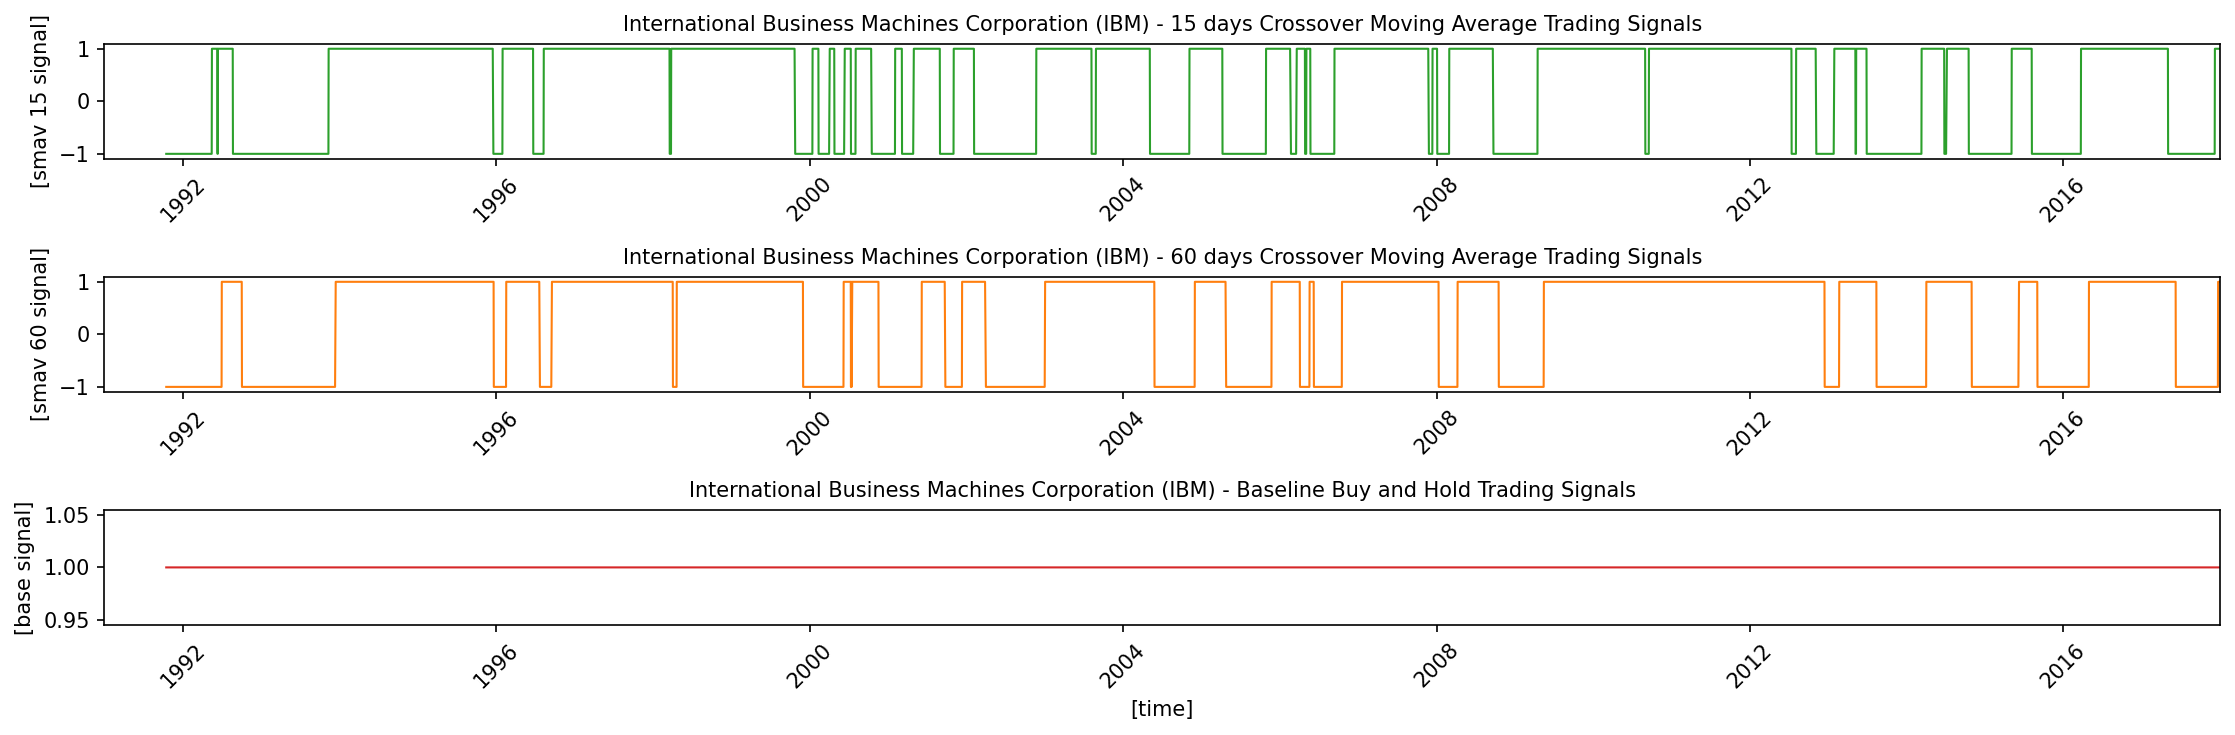

In [109]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(ncols=1, nrows=3)

ax[0].plot(cross_mav_ibm_signal_data['SIGNAL_15'], lw=1.0, color='C2', label='SMAV 15 (red)')
ax[1].plot(cross_mav_ibm_signal_data['SIGNAL_60'], lw=1.0, color='C1', label='SMAV 60 (green)')
ax[2].plot(cross_mav_ibm_signal_data['SIGNAL_BASE'], lw=1.0, color='C3', label='BASE (purple)')
    
# set axis labels
plt.xlabel('[time]', fontsize=10)
ax[0].set_xlim([start_date, end_date])
ax[0].set_ylabel('[smav 15 signal]', fontsize=10)
ax[1].set_xlim([start_date, end_date])
ax[1].set_ylabel('[smav 60 signal]', fontsize=10)
ax[2].set_xlim([start_date, end_date])
ax[2].set_ylabel('[base signal]', fontsize=10)

# rotate the x-axis labels
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
    
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
    
for tick in ax[2].get_xticklabels():
    tick.set_rotation(45)

# set plot title
ax[0].set_title('International Business Machines Corporation (IBM) - 15 days Crossover Moving Average Trading Signals', fontsize=10)
ax[1].set_title('International Business Machines Corporation (IBM) - 60 days Crossover Moving Average Trading Signals', fontsize=10)
ax[2].set_title('International Business Machines Corporation (IBM) - Baseline Buy and Hold Trading Signals', fontsize=10)

# reset plot layout
plt.tight_layout()

Let's determine the total number of **long-short signal changes** of the distinct trading strategies. For that we will count the number of time the signal is positive. We will use the itertool library which allows to manipulate and apply functions on a list of elements.

In [ ]:
# first, lets isolate one signal.
only_signal_15 = cross_mav_ibm_signal_data['SIGNAL_15']

# then, lets use the groupby function of the itertool
# it takes an iterable applies a function to it and groups it by this function result and gives back an iterable
only_signal_15_groupby = it.groupby(only_signal_15, lambda x: x > 0)

# to see the result, we must convert it from an iterable (a complex object) to a list (something we can look at)
list_only_signal_15_groupby = list(only_signal_15_groupby)

# then we just count the number of elements in the list
len(list_only_signal_15_groupby)

64

In [119]:
# signal changes of the 60-200 days moving average crossover trading strategy
len(list(it.groupby(cross_mav_ibm_signal_data['SIGNAL_60'], lambda x: x > 0)))

44

In [113]:
# signal changes of the baseline buy and hold trading strategy
len(list(it.groupby(cross_mav_ibm_signal_data['SIGNAL_BASE'], lambda x: x > 0)))

1

### 5. Moving Average Crossover Signal Backtest

Prepare the market data to be utilized in backtesting the crossover moving average trading strategy configurations:

In [120]:
# extract the ibm stock closing prices
ibm_market_data = pd.DataFrame(ibm_data['Close'], columns=['Close'])

# rename the 'close' column to 'ibm' (since this is the column we want to allocate to in the backtest)
ibm_market_data = ibm_market_data.rename(columns={'Close': 'IBM'})

# convert pandas DataFrame index to datatype: datetime
ibm_market_data = ibm_market_data.set_index(pd.to_datetime(ibm_data.index))

Inspect top 10 rows of the prepared market data:

In [121]:
ibm_market_data.head(10)

,IBM
Date,
1990-12-31 00:00:00-05:00,11.809528
1991-01-02 00:00:00-05:00,11.718080
1991-01-03 00:00:00-05:00,11.757276
1991-01-04 00:00:00-05:00,11.718080
1991-01-07 00:00:00-05:00,11.522127
1991-01-08 00:00:00-05:00,11.391491
1991-01-09 00:00:00-05:00,11.169409
1991-01-10 00:00:00-05:00,11.326175
1991-01-11 00:00:00-05:00,11.300041


Implementing a simple Moving Average Trading Strategy by interfacing the Python `bt`'s Algo class:

In [122]:
class MovingAverageStrategy(bt.Algo):
    
    # inits the strategy
    def __init__(self, signals):
        
        # set class signals
        self.signals = signals
        
    # calls the trading strategy
    def __call__(self, target):
        
        # case: current timestep in signals
        if target.now in self.signals.index[1:]:
            
            # get actual signal
            signal = self.signals[target.now]
            
            # set target weights according to signal
            target.temp['weights'] = dict(IBM=signal)
            
        # return 'True' since we want to move on to the next timestep
        return True

Define the moving average trading strategy backtest algorithm stack. 

**Note:** That in the Python `bt` library a trading strategy usually consists of a so-called **stack of algorithms**. For each timestep of our backtest timeframe, the `bt` library executes all algorithm of the stack in sequential order. Each moving average strategy we aim to design and backtest consists in total of three algorithms, briefly described in the following: 

> 1. `bt.algos.SelectAll()`: Selects all available stocks for trading except stock prices that correspond to NaN or 0.00.  
> 2. `MovingAverageStrategy()`: Assigns the calculated signal in terms of a weight value to the IBM stock.
> 3. `bt.algos.Rebalance()`: Rebalances the available capital based on the weights assigned to each stock.

Define the long-/short-term moving average trading strategy backtest algorithm stack: 

In [123]:
cross_mav_ibm_strategy_15 = bt.Strategy(name='smav_15', algos=[bt.algos.SelectAll(), MovingAverageStrategy(cross_mav_ibm_signal_data['SIGNAL_15']), bt.algos.Rebalance()])
cross_mav_ibm_strategy_60 = bt.Strategy(name='smav_60', algos=[bt.algos.SelectAll(), MovingAverageStrategy(cross_mav_ibm_signal_data['SIGNAL_60']), bt.algos.Rebalance()])
cross_mav_ibm_strategy_base = bt.Strategy(name='base', algos=[bt.algos.SelectAll(), MovingAverageStrategy(cross_mav_ibm_signal_data['SIGNAL_BASE']), bt.algos.Rebalance()])

Let's now define the trading ('fees') commissions used in each rebalancing time-step of a backtest. To achieve this, the `bt` library expects a callable function that expects the following two parameters as an input:

> - the 'quantity', denoted by `q`, of rebalanced assets at a backtest time-step;
> - the 'price', denoted by `p`, of rebalanced assets at a backtest time-step.

Let's implement such a callable function defining a trading fee of **1\% (0.01)** per quantity of rebalanced asset (or a flat fee of **USD 5.00** per trade):

In [124]:
# init trading fees function
def trading_fees_function(q, p):
    
    # calcluate trading fees (rebalanced-quantity * trading-fee)
    fees = q * 0.01 # non-flat fee of 1% per quantity of rebalanced asset
    # fees = 5.00 # flat fee of USD 5.00 per trade
    
    # return the total trading fees
    return fees

Upon completion of defining the long-/sort-term moving average strategies let's now init the corresponding backtests using (1) both strategies as well as (2) the market data that we aim to evaluate during the backtest:

In [125]:
ibm_backtest_cross_mav_15 = bt.Backtest(strategy=cross_mav_ibm_strategy_15, data=ibm_market_data, name='ibm_backtest_smav_15', commissions=trading_fees_function, progress_bar=True)
ibm_backtest_cross_mav_60 = bt.Backtest(strategy=cross_mav_ibm_strategy_60, data=ibm_market_data, name='ibm_backtest_smav_60', commissions=trading_fees_function, progress_bar=True)
ibm_backtest_cross_mav_base = bt.Backtest(strategy=cross_mav_ibm_strategy_base, data=ibm_market_data, name='ibm_backtest_smav_base', commissions=trading_fees_function, progress_bar=True)

Now, let's run the backtest of both configurations of the crossover moving average strategy as well as the defined baseline:

In [126]:
backtest_results_ibm = bt.run(ibm_backtest_cross_mav_15, ibm_backtest_cross_mav_60, ibm_backtest_cross_mav_base)

  0%|          | 0/3 [00:00<?, ?it/s]

ibm_backtest_smav_15
0% [############################# ] 100% | ETA: 00:00:00

 33%|███▎      | 1/3 [00:02<00:05,  2.83s/it]

ibm_backtest_smav_60
0% [############################# ] 100% | ETA: 00:00:00

 67%|██████▋   | 2/3 [00:05<00:02,  2.94s/it]

ibm_backtest_smav_base
0% [############################# ] 100% | ETA: 00:00:00

100%|██████████| 3/3 [00:08<00:00,  2.91s/it]


Inspect the individual backtest results and performance measures:

In [127]:
backtest_results_ibm.display()

Stat                 ibm_backtest_smav_15    ibm_backtest_smav_60    ibm_backtest_smav_base
-------------------  ----------------------  ----------------------  ------------------------
Start                1990-12-30              1990-12-30              1990-12-30
End                  2017-12-29              2017-12-29              2017-12-29
Risk-free rate       0.00%                   0.00%                   0.00%

Total Return         35.94%                  -83.38%                 865.46%
Daily Sharpe         0.18                    -0.10                   0.44
Daily Sortino        0.29                    -0.16                   0.74
CAGR                 1.14%                   -6.43%                  8.76%
Max Drawdown         -86.02%                 -94.10%                 -59.36%
Calmar Ratio         0.01                    -0.07                   0.15

MTD                  0.12%                   1.45%                   -0.36%
3m                   -7.55%                  -6.32

Collect detailed backtest performance per timestep of the "fast" **15-200 days** crossover moving average strategy:

In [130]:
backtest_sma_15_ibm_details = ibm_backtest_cross_mav_15.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_sma_15_ibm_details['Abs. EQUITY'] = ibm_backtest_cross_mav_15.strategy.values # equity per timestep
backtest_sma_15_ibm_details['CASH'] = ibm_backtest_cross_mav_15.strategy.cash # cash per timestep
backtest_sma_15_ibm_details['POSITIONS'] = ibm_backtest_cross_mav_15.strategy.positions # positions per timestep
backtest_sma_15_ibm_details['FEES'] = ibm_backtest_cross_mav_15.strategy.fees # trading fees per timestep

Inspect detailed backtest results per timestep:

In [131]:
backtest_sma_15_ibm_details.head(10)

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
1990-12-30 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1990-12-31 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-02 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-03 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-04 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-07 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-08 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-09 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-10 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-11 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0


Visualize the monthly returns obtained by the **15-200 days** crossover moving average strategy:

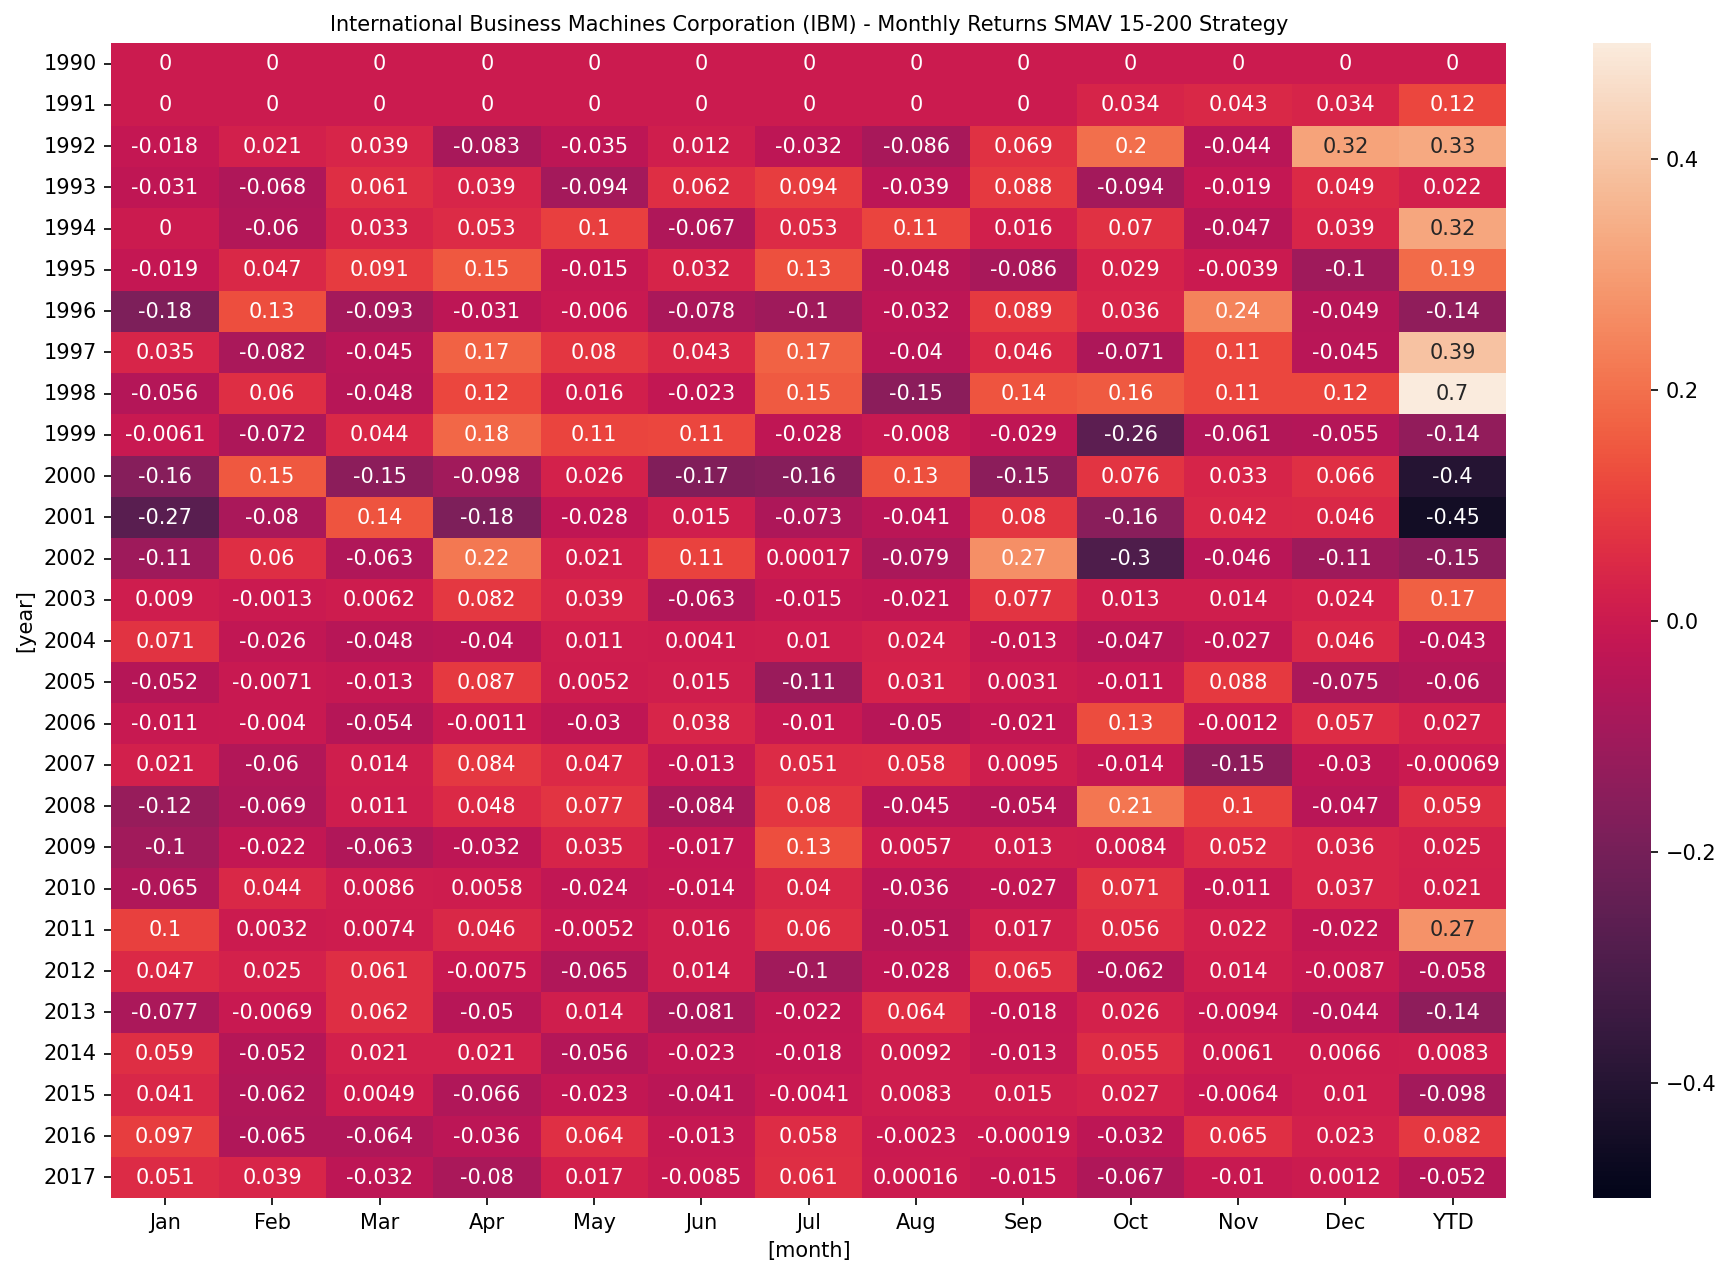

In [132]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(ibm_backtest_cross_mav_15.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns SMAV 15-200 Strategy', fontsize=10);

Collect detailed backtest performance per timestep of the "slow" **60-200 days** crossover moving average strategy:

In [133]:
backtest_sma_60_ibm_details = ibm_backtest_cross_mav_60.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_sma_60_ibm_details['Abs. EQUITY'] = ibm_backtest_cross_mav_60.strategy.values # equity per timestep
backtest_sma_60_ibm_details['CASH'] = ibm_backtest_cross_mav_60.strategy.cash # cash per timestep
backtest_sma_60_ibm_details['POSITIONS'] = ibm_backtest_cross_mav_60.strategy.positions # positions per timestep
backtest_sma_60_ibm_details['FEES'] = ibm_backtest_cross_mav_60.strategy.fees # fees per timestep

Inspect detailed backtest results per timestep:

In [134]:
backtest_sma_60_ibm_details.head(10)

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
1990-12-30 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1990-12-31 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-02 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-03 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-04 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-07 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-08 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-09 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-10 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-11 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0


Visualize the monthly returns obtained by the **60-200 days** crossover moving average strategy:

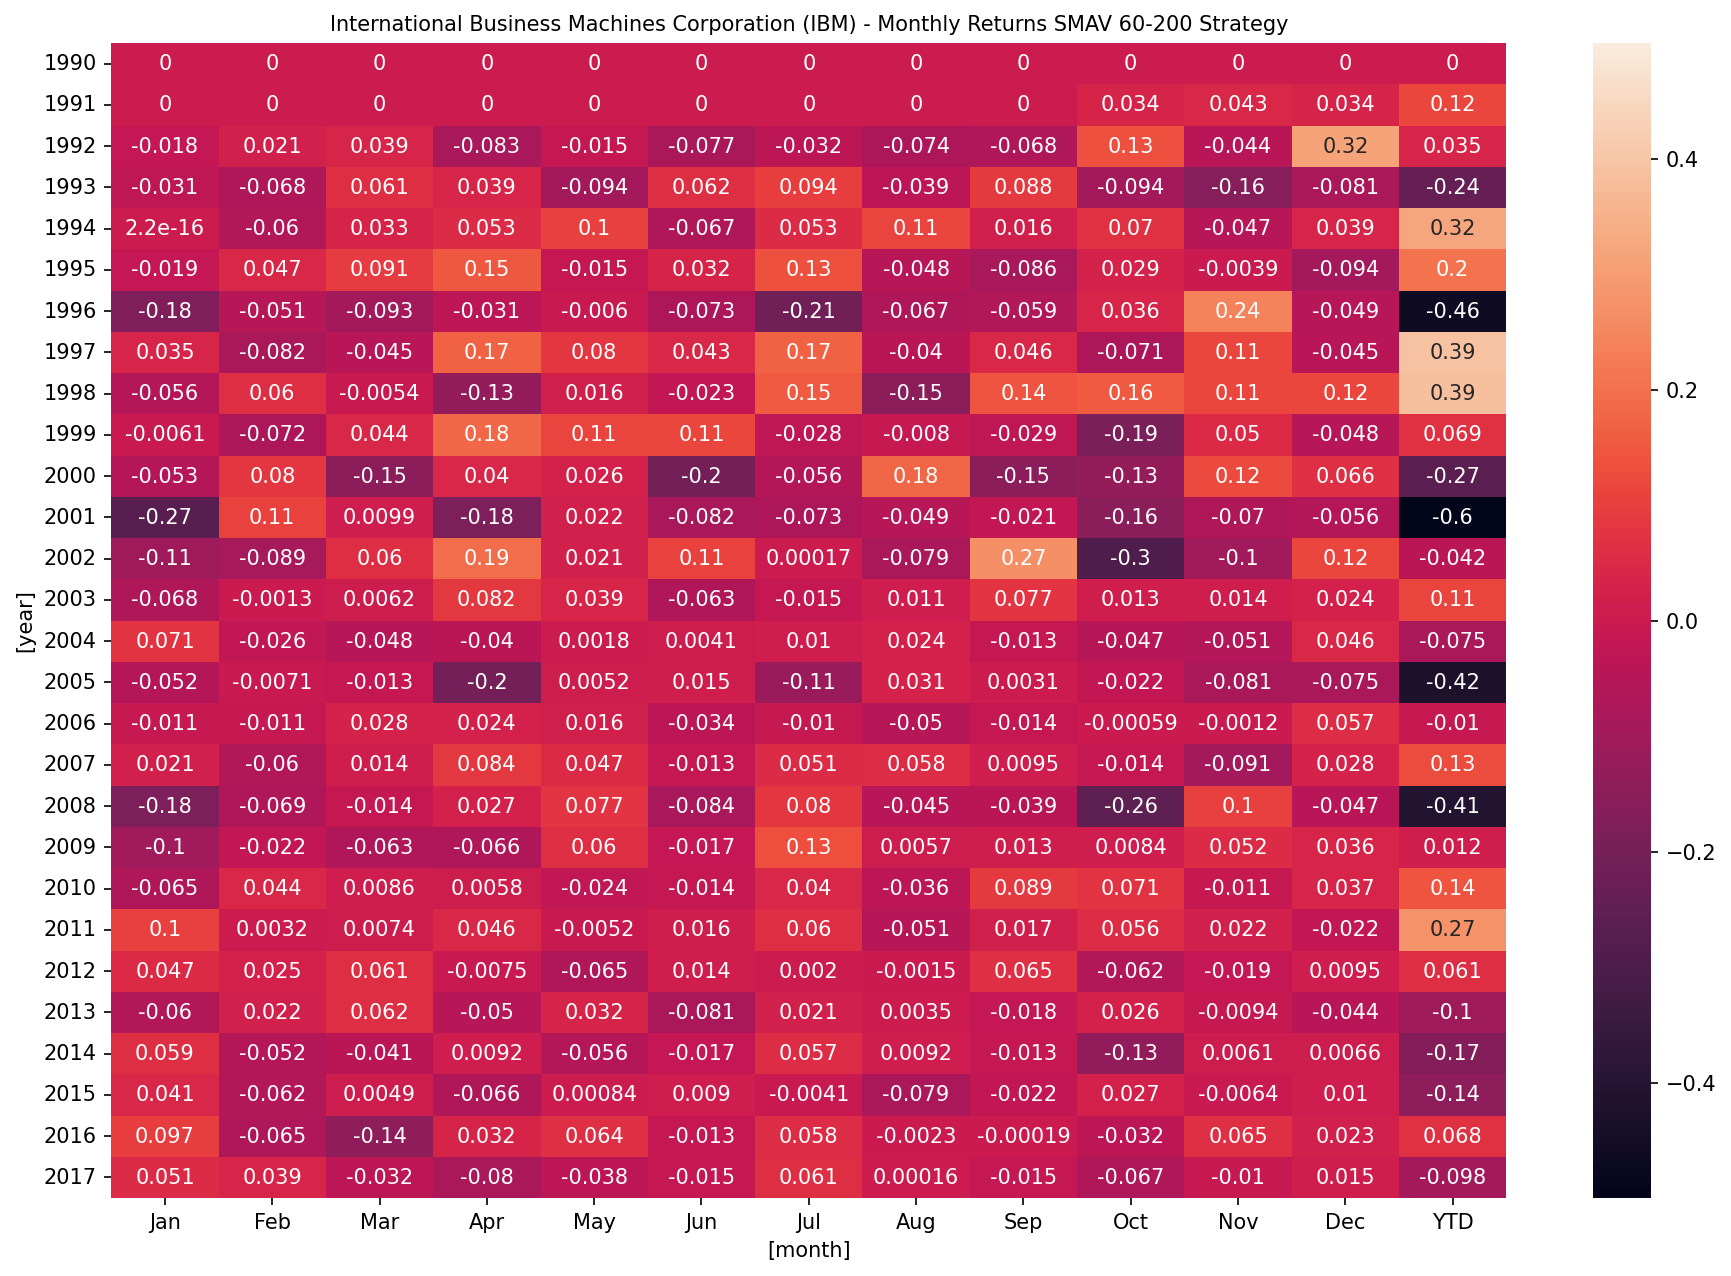

In [135]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(ibm_backtest_cross_mav_60.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns SMAV 60-200 Strategy', fontsize=10);

Collect detailed backtest performance per timestep of the "long only" baseline strategy:

In [136]:
backtest_sma_base_ibm_details = ibm_backtest_cross_mav_base.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_sma_base_ibm_details['Abs. EQUITY'] = ibm_backtest_cross_mav_base.strategy.values # equity per timestep
backtest_sma_base_ibm_details['CASH'] = ibm_backtest_cross_mav_base.strategy.cash # cash per timestep
backtest_sma_base_ibm_details['POSITIONS'] = ibm_backtest_cross_mav_base.strategy.positions # positions per timestep
backtest_sma_base_ibm_details['FEES'] = ibm_backtest_cross_mav_base.strategy.fees # fees per timestep

Inspect detailed backtest results per timestep:

In [137]:
backtest_sma_base_ibm_details.head(10)

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
1990-12-30 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1990-12-31 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-02 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-03 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-04 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-07 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-08 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-09 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-10 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-11 00:00:00-05:00,100.0,1000000.0,1000000.0,0.0,0.0


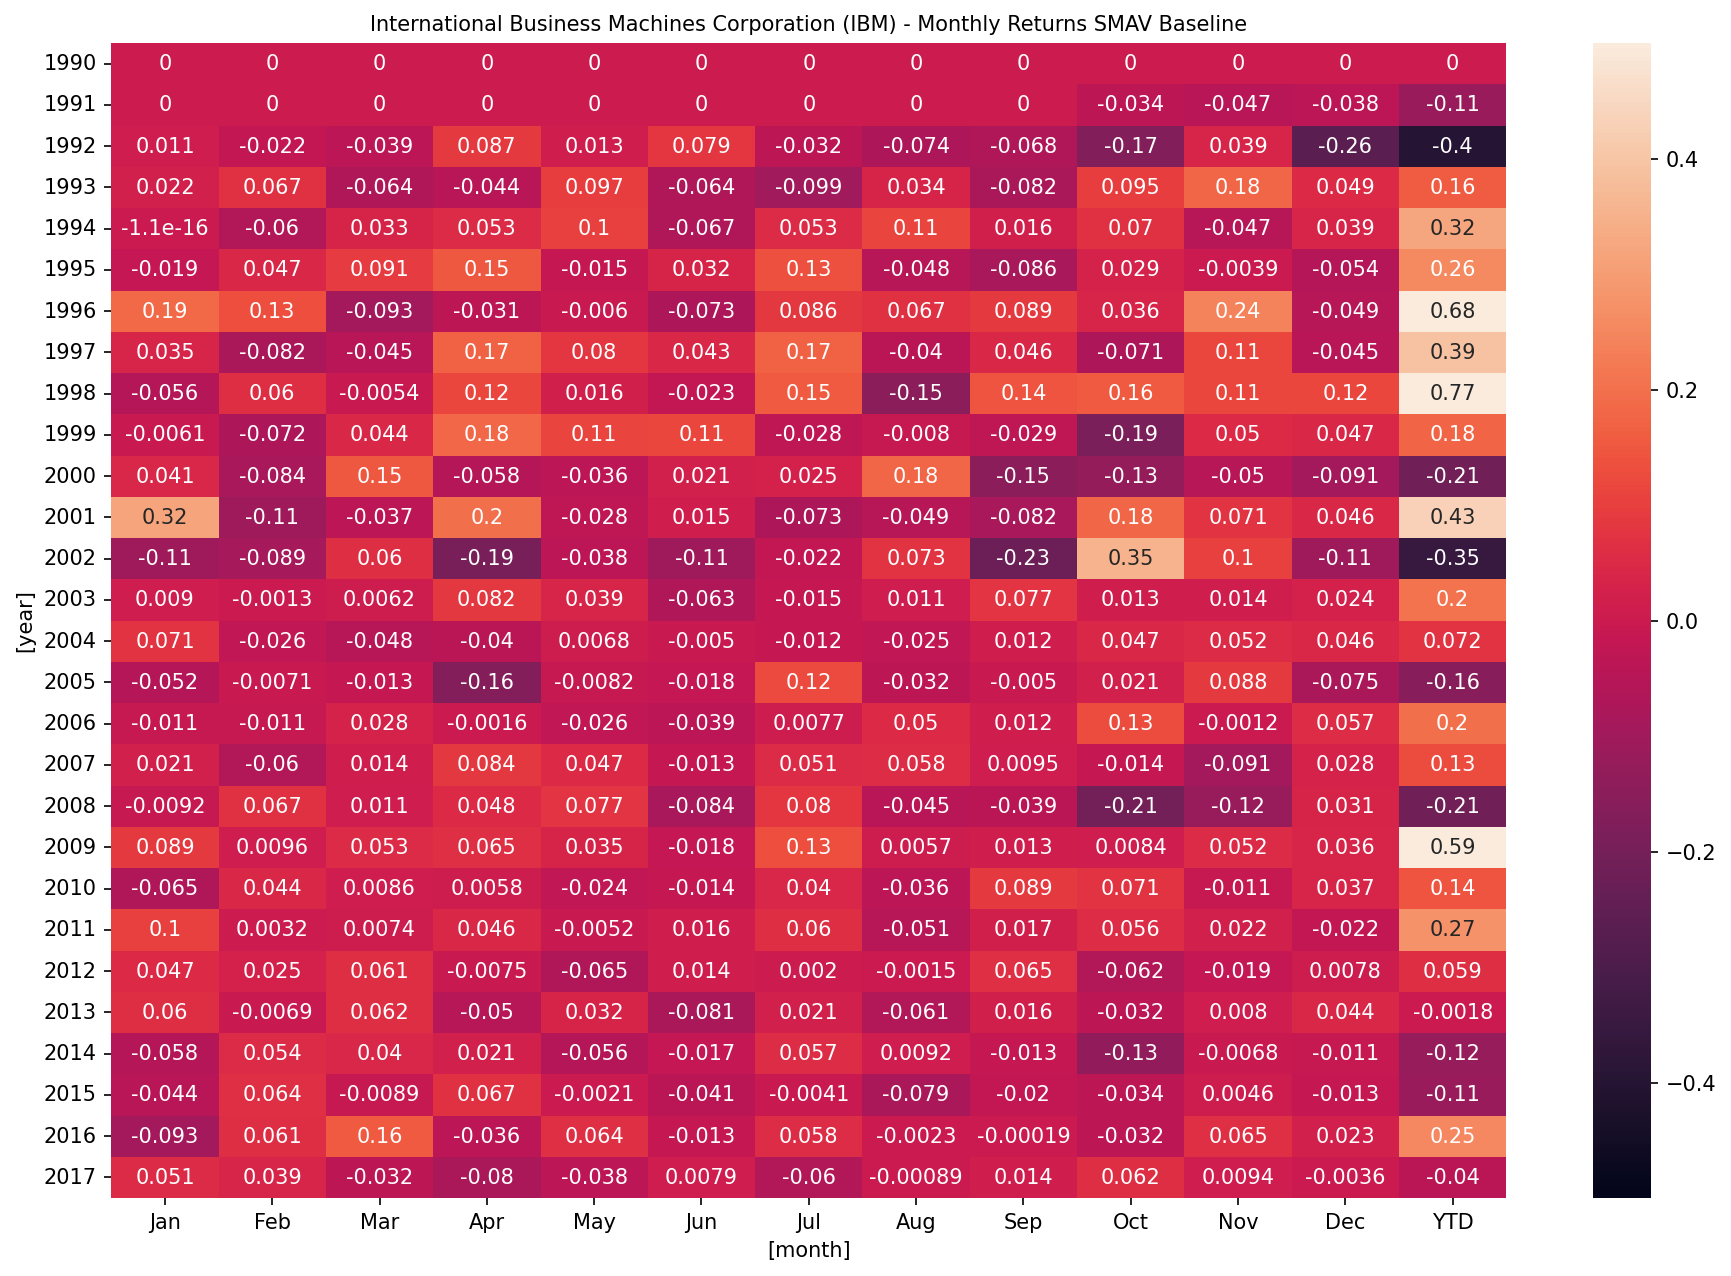

In [138]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(ibm_backtest_cross_mav_base.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns SMAV Baseline', fontsize=10);

Visualize each strategie's backtest equity progression over time:

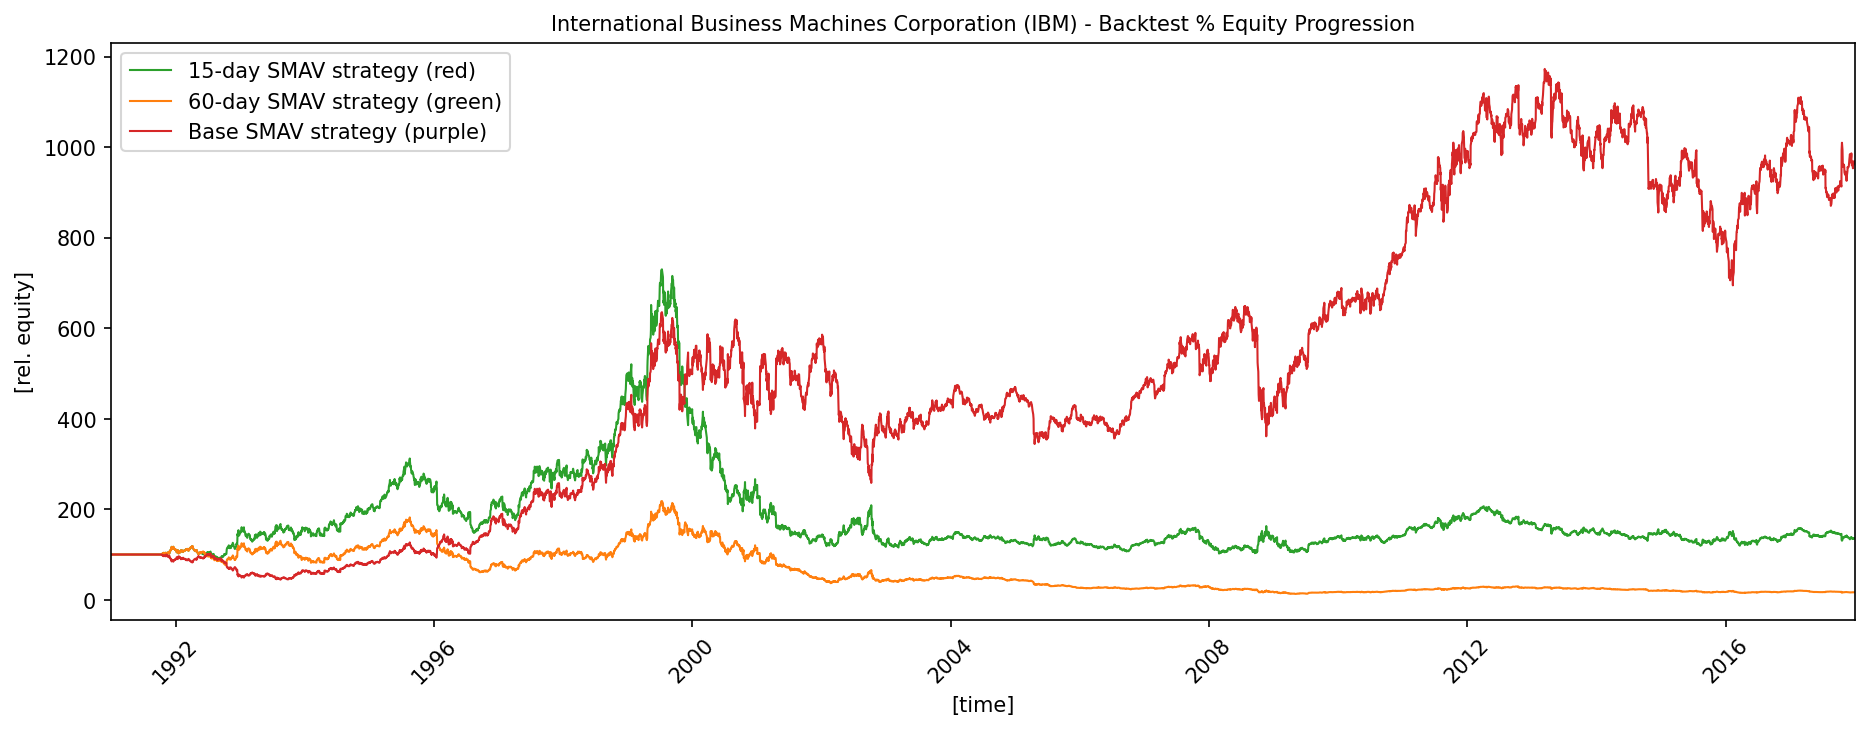

In [139]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot equity progression of the distinct trading strategies
ax.plot(backtest_sma_15_ibm_details['Rel. EQUITY'], color='C2',lw=1.0, label='15-day SMAV strategy (red)')
ax.plot(backtest_sma_60_ibm_details['Rel. EQUITY'], color='C1',lw=1.0, label='60-day SMAV strategy (green)')
ax.plot(backtest_sma_base_ibm_details['Rel. EQUITY'], color='C3',lw=1.0, label='Base SMAV strategy (purple)')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[rel. equity]', fontsize=10)

# set plot legend
plt.legend(loc="upper left", numpoints=1, fancybox=True)

# set plot title
plt.title('International Business Machines Corporation (IBM) - Backtest % Equity Progression', fontsize=10);

## Lab Exercises:

We recommend you to try the following exercises as part of the lab:

**1. Evaluation of distinct daily moving average parameters.**

> Evaluate the simple crossover moving average trading strategy using distinct moving average look-backs, e.g., 10 days, 30 days, 50 days, 200 days and 300 days. Compare the performance of the lookback parametrizations in terms of total-return, equity progression and yearly sharpe-ratio. Gain an intuition about the years in which the strategy didn't perform well and the potential reason for the poor performance.

In [ ]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**2. Evaluation of distinct trading frequencies.** 

>Decreasing the lookback in calculating the moving average may results in a significant increase of the corresponding trading frequency (referred to as 'signal changes', and defined as a change of the trading signal from -1 to 1 and vice versa). Calculate the number of signal changes for each of the distinct lookback parametrizations evaluated in the first exercise.

In [ ]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**3. Consideration of trading commissions and impact on strategy performance.** 

>Run the backtest of the lookback parametrizations evaluated in exercise 1. but change the commission per trade. Set the trading commission of each backtest to (i) 10 USD per trade and (ii) 1% of the price per share. Determine the impact of such a trading fee on the performance of each strategy in terms of total-return, equity progression and yearly sharpe-ratio.

In [ ]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**4. Optimization of the simple crossover moving average trading strategy parameters.**

>The lab notebook backtest results obtained for the simple crossover moving average trading strategy reveals that we didn't identify a well-performing strategy parametrization yet. Grid search the parameter space of the strategy to determine a parametrization that results in a positive total-return within the time interval 30.12.1990 until 31.12.2017.

In [ ]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**5. Implementation of a long-/short-term exponential moving average trading strategy.**

>A potential further enhancement of the simple crossover moving average trading strategy lies in the application of exponentially weighted moving averages. Adapt the crossover trading strategy of this notebook using an exponential moving average instead of the equally weighted moving average (hint: you may want to use the `ewm()` of the Pandas library). Evaluate the performance of the exponential moving average trading strategy using distinct alpha parameters, e.g.: 0.2, 0.5 and 0.8. 

In [ ]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

## Lab Summary:

In this lab, a step by step implementation and backtest of a basic **moving average trading strategy** using the Python programming language is presented. The implemented strategy trades a specific financial instrument based on its adjusted closing price trend. The degree of success of the implemented strategy is evaluated based os its backtest results with particular focus on (1) the strategy's **total return** as well as (2) its **equity progression** over time. The code provided in this lab provides a blueprint to develop and backtest more complex trading strategies. It furthermore can be tailored to be applied for momentum trading of other financial instruments.

You may want to execute the content of your lab outside of the Jupyter notebook environment, e.g. on a compute node or a server. The cell below converts the lab notebook into a standalone and executable python script. Pls. note that to convert the notebook, you need to install Python's **nbconvert** library and its extensions:

In [ ]:
# installing the nbconvert library
!pip3 install nbconvert
!pip3 install jupyter_contrib_nbextensions

Let's now convert the Jupyter notebook into a plain Python script:

In [ ]:
!jupyter nbconvert --to script cfds_lab_03.ipynb